# Supplementary figures for the data release about the waveform phase

In [36]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio
from scipy.stats import pearsonr

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../../utils/plotting.mplstyle')
from matplotlib.lines import Line2D
from scipy.signal import find_peaks

import seaborn as sns
sns.set_palette('coolwarm')

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("my_cmap", ['C3','C5', 'C0'])

import sys
sys.path.append('../../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../../data/different_extrinsic_angles/'

### Setup

Load data

In [2]:
# Load in the maxL parameters
maxL_params = h5ify.load(data_dir+'../real_and_maxL_GW190521/GW190521_maxL_parameters.h5')

# Injected waveforms
injected_wf_dict = h5ify.load('/home/simona.miller/heavy-bbh-td-inference/figures/paper_I/figure_07_injected_waveforms.h5')

# Load in JSDs and pre-merger strain values
JSD_dict = h5ify.load(data_dir+'JSDs_different_angles.h5')
premerger_strain_dict = h5ify.load(data_dir+'pre_merger_strain_amp_different_angles.h5')

Set up plotting aesthetics

In [3]:
# Parameters to plot
phases = [0.0, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.5, 3.0]
psis = ['0.00', '0.15', '0.25', '0.35', '0.50', '0.60', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95']
iotas = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0]

params_to_plot = {
    'iota':iotas, 
    'psi':psis, 
    'phase':phases,
}

labels = {
    'phase':r'$\varphi$', 
    'psi':r'$\psi$', 
    'iota':r'$\iota$'
}
maxL_p_values = {'phase':1.3, 'psi':2.3, 'iota':1.16}

In [5]:
injected_wf_dict.keys()

dict_keys(['iota 0.0', 'iota 0.5', 'iota 1.0', 'iota 1.25', 'iota 1.5', 'iota 1.75', 'iota 2.0', 'iota 2.25', 'iota 2.5', 'iota 3.0', 'phase 0.0', 'phase 0.3', 'phase 0.5', 'phase 0.6', 'phase 0.7', 'phase 0.8', 'phase 1.0', 'phase 1.2', 'phase 1.3', 'phase 1.4', 'phase 1.5', 'phase 1.7', 'phase 2.0', 'phase 2.5', 'phase 3.0', 'pol 0.00', 'pol 0.15', 'pol 0.25', 'pol 0.35', 'pol 0.50', 'pol 0.60', 'pol 0.70', 'pol 0.75', 'pol 0.80', 'pol 0.85', 'pol 0.90', 'pol 0.95'])

### Make Figure

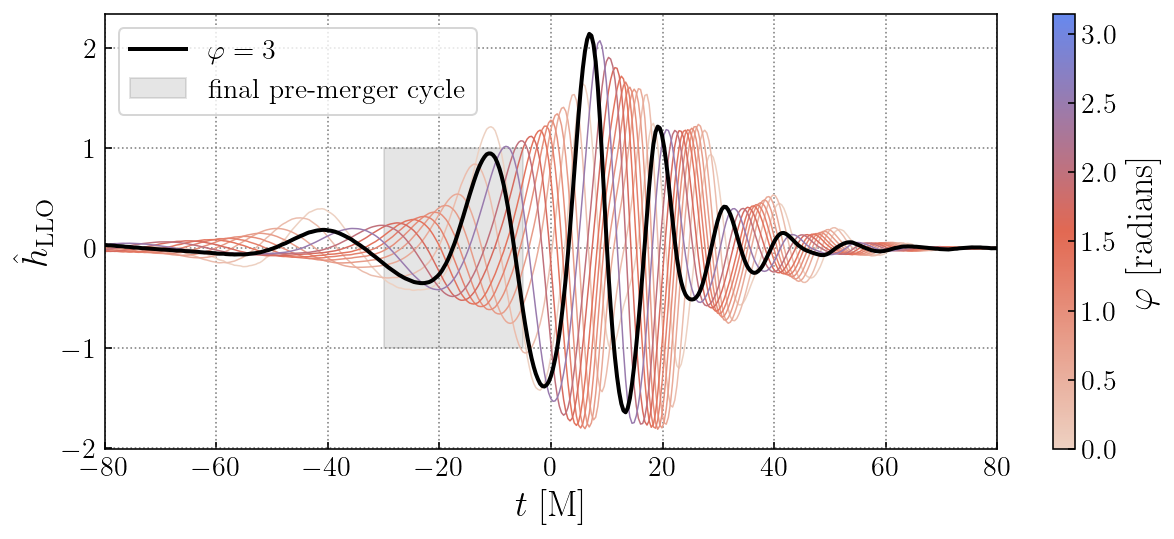

In [136]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

for i, p in enumerate(phases): 

    k = pf.get_key(p, 'phase')
    if p==3.0:
        kws = dict(color='k', lw=2, label=r'$\varphi=3$')
    else:
        kws = dict(color=pf.get_color(p, 'phase', cmap), lw=0.75)
    
    wh = injected_wf_dict[k]['strain_wh']['L1']
    times_s = injected_wf_dict[k]['time_dict']['L1'] - maxL_params['L1_time']
    times_M = pf.transform_s_to_M(times_s, maxL_params['mtotal'])
    
    plt.plot(times_M, wh, **kws)
    
plt.fill_between([-30,-5], -1, y2=1, alpha=0.1, color='k', zorder=0, label='final pre-merger cycle')

plt.xlim(-80,80)
plt.xlabel('$t$ [M]')
plt.ylabel(r'$\hat h_{\rm LLO}$')
plt.legend(frameon=True)

cnorm = matplotlib.colors.Normalize(vmin=0, vmax=np.pi)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap), ax=ax,
             orientation='vertical', label=r'$\varphi$ [radians]')

plt.savefig('phases_wfs.png', dpi=600, bbox_inches='tight')
plt.show()

In [123]:
def get_premerger_strain_quantity(inj, inj_params, tcut, hmax=1): 
    
    # whitened strain 
    strain_wh = inj['strain_wh']['L1']
    
    if isinstance(strain_wh, list): 
        strain_wh = np.asarray(strain_wh)
        
    # calculate times in units of M
    _times = inj['time_dict']['L1'] 
    if isinstance(_times, list): 
        _times = np.asarray(_times) 
    
    times = _times - inj_params['L1_time']
    M = inj_params['mtotal']
    times_M = pf.transform_s_to_M(times, M)
    
    # only look at premerger, as defined by the argument tcut
    mask = (times_M < tcut)

    # calculate all the local maxima in the time series
    peak_idxs, peaks_dict = find_peaks(np.abs(strain_wh[mask]), height = (0.001,hmax))

    # get the peak of the informative cycle
    p_i = -1
    s = peaks_dict['peak_heights'][p_i]
    s_abs = strain_wh[mask][peak_idxs[p_i]]
        
    # ratio of the informative cycle vs the over-all max strain
    i_max = np.argmax(np.abs(strain_wh))
    s_max = strain_wh[i_max]
    r = s / np.abs(s_max)
  
    return r


premerger_strain_dict = {}

TCUTS = [-10, -5, 0]
hmaxes = [0.8, 1, 1.2]

for TCUT in TCUTS:
    premerger_strain_dict_ = {}
    for hmax in hmaxes:
        premerger_strain_dict__ = {}
        for p_name in params_to_plot.keys():
            final_premerger_strains = [] 
            for p in params_to_plot[p_name]: 

                # calculate key for this parameter
                k = pf.get_key(p, p_name)

                # fetch injection
                inj = injected_wf_dict[k]

                # get the desired quantities
                r = get_premerger_strain_quantity(inj, maxL_params, TCUT, hmax=hmax)

                final_premerger_strains.append(r)

            premerger_strain_dict__[p_name] = final_premerger_strains
        premerger_strain_dict_[hmax] = premerger_strain_dict__
    premerger_strain_dict[TCUT] = premerger_strain_dict_

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\h'
/local/simona.miller/ipykernel_3879481/2413430937.py:20: SyntaxWarning: invalid escape sequence '\c'
  axes[1][0].set_ylabel('JSD between full $\chi_p$ posterior and prior')
/local/simona.miller/ipykernel_3879481/2413430937.py:21: SyntaxWarning: invalid escape sequence '\h'
  axes[2][1].set_xlabel('ratio of peak $|\hat h|$ in pre-merger cycle to overall peak of $|\hat h|$')


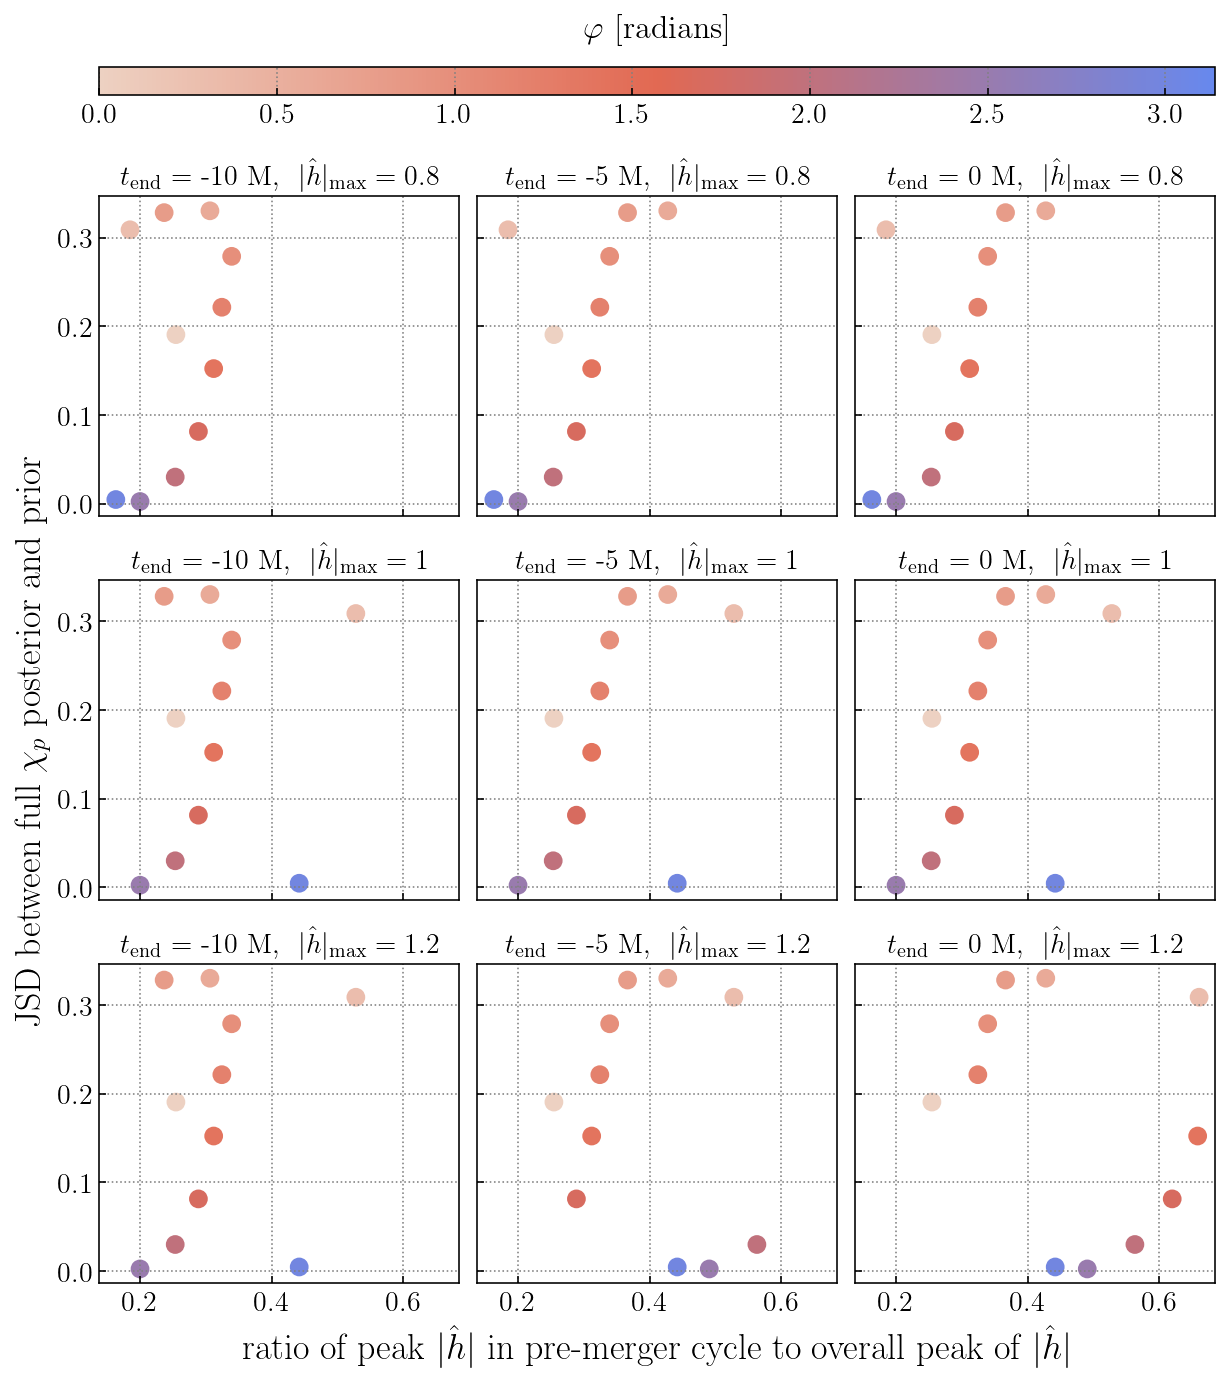

In [137]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

colors = [pf.get_color(x, 'phase', cmap) for x in params_to_plot['phase']]
                         

for ax, TCUT, hmax in zip(axes.flatten(),
                             [-10, -5, 0, -10, -5, 0, -10, -5, 0], 
                             [0.8, 0.8, 0.8, 1, 1, 1, 1.2, 1.2, 1.2]):
    ax.scatter(premerger_strain_dict[TCUT][hmax]['phase'], JSD_dict['phase'], c=colors, s=70)
    ax.set_title(fr'$t_{{\rm end}}$ = {TCUT} M, $~|\hat h|_{{\rm max}} = {hmax}$', fontsize=14)


cax = plt.axes((0.125, 0.95, 0.775, 0.02)) #(left, bottom, width, height)
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=np.pi)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax, orientation='horizontal')
cax.set_title(r'$\varphi$ [radians]', fontsize=16, y=1.6)

plt.subplots_adjust(wspace=0.05)

axes[1][0].set_ylabel('JSD between full $\chi_p$ posterior and prior')
axes[2][1].set_xlabel('ratio of peak $|\hat h|$ in pre-merger cycle to overall peak of $|\hat h|$')

plt.savefig('phases_JSD_vs_strain.png', dpi=600, bbox_inches='tight')
plt.show()